In [1]:
import numpy as np

import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).

In [2]:
# генерация данных
classification_data, classification_labels = datasets.make_classification(n_features = 5, n_informative = 2,
                                                                         n_classes = 2, n_redundant = 0,
                                                                         n_clusters_per_class = 1, random_state = 5)

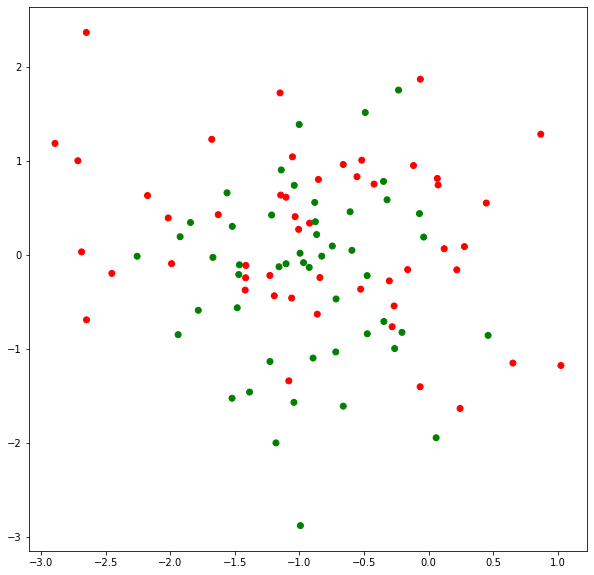

In [3]:
# визуализируем сгенерированные данные
colors = ListedColormap(['red', 'green'])
light_colors = ListedColormap(['lightcoral', 'lightgreen'])

plt.figure(figsize=(10,10))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
           c=classification_labels, cmap=colors)

In [4]:
# реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t # значение порога
        self.true_branch = true_branch # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch # поддерево, не удовлетворяющее условию в узле

In [5]:
# класс терминального узла(листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчёт количества объектов разных классов
        classes = {} # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его
        prediction = max(classes, key=classes.get)
        return prediction

In [6]:
# расчёт критерия Джини
def gini(labels):
    # подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] = 1
        
    # расчёт критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
    
    return impurity

In [7]:
# расчёт качества
def quality(left_labels, right_labels, current_gini):
    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# разбиение датасета в узле
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
    
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
    
    return true_data, false_data, true_labels, false_labels

In [9]:
# нахождение лучшего разбиения
def find_best_split(data, labels, n_features, min_leaf):
    # реализована возможность выбора количества признаков и минимального количества объектов в узле
    
    current_gini = gini(labels)
    
    best_quality = 0
    best_t = None
    best_index = None
    
    if n_features > data.shape[1]:
        n_features = data.shape[1]
        
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            # пропускаем разбиения, в которых в узле остается менее min_leaf объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            # выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index
                
    return best_quality, best_t, best_index

In [10]:
# построение дерева с помощью рекурсивной функции
def build_tree(data, labels, n_features, min_leaf, depth=1, max_depth=9):

    quality, t, index = find_best_split(data, labels, n_features, min_leaf)
    
    #  базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or depth == max_depth:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, n_features, min_leaf, depth+1, max_depth)
    false_branch = build_tree(false_data, false_labels, n_features, min_leaf, depth+1, max_depth)

    # возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
# проход объекта по дереву для его классификации
def classify_object(obj, node):

    #  останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
# предсказание деревом для всего датасета
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
# разобьем выборку на обучающую и тестовую
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                            classification_labels, test_size = 0.3, random_state = 1)

In [14]:
# введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [15]:
tree = build_tree(train_data, train_labels, n_features=5, min_leaf=7)

In [16]:
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(tree)

Индекс 1
Порог 1.042057360092263
--> True:
  Индекс 0
  Порог -1.9910852219422726
  --> True:
    Прогноз: 0
  --> False:
    Индекс 1
    Порог 0.6593659328231258
    --> True:
      Индекс 1
      Порог 0.34337204957880313
      --> True:
        Индекс 0
        Порог -1.4207600680736312
        --> True:
          Прогноз: 1
        --> False:
          Индекс 0
          Порог -0.03761800945558491
          --> True:
            Индекс 0
            Порог -1.1587284262397282
            --> True:
              Прогноз: 1
            --> False:
              Индекс 0
              Порог -0.9247542848547602
              --> True:
                Прогноз: 1
              --> False:
                Прогноз: 1
          --> False:
            Прогноз: 0
      --> False:
        Прогноз: 0
    --> False:
      Прогноз: 0
--> False:
  Прогноз: 0


In [17]:
train_res = predict(train_data, tree)

In [18]:
result = predict(test_data, tree)

In [19]:
train_acc = accuracy_metric(train_labels, train_res)

In [20]:
test_acc = accuracy_metric(test_labels, result)

In [21]:
print(f'Точность при обучении: {train_acc:.3f}, на тесте: {test_acc:.3f}')

Точность при обучении: 68.571, на тесте: 63.333


Text(0.5, 1.0, 'Test accuracy=63.33')

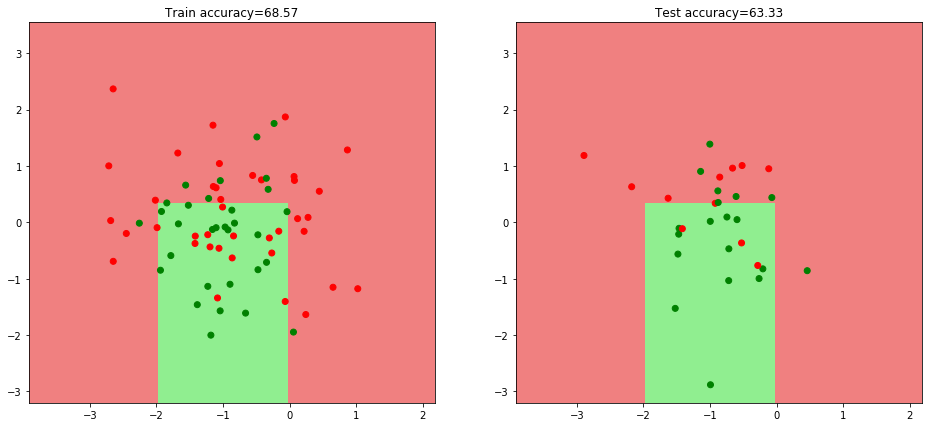

In [22]:
# визуализируем дерево на графике
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_acc:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_acc:.2f}')

3 [опция]. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [23]:
data, labels = datasets.make_regression(n_features=2, random_state=5)

In [24]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [25]:
class Leaf:   
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        objects = []  # сформируем список объектов в листе
        for label in self.labels:
            objects.append(label)
        #  найдем среднее    
        objects = np.array(objects)
        prediction = objects.mean()
        return prediction

In [26]:
def variance(labels):
    objects = []  
    for label in labels:
        objects.append(label)
    objects = np.array(objects)
    pred = objects.mean()
    return np.mean((labels - pred) ** 2)

In [27]:
def quality(left_labels, right_labels, current_variance):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_variance - p * variance(left_labels) - (1 - p) * variance(right_labels)

In [28]:
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [29]:
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_variance = variance(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_variance)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [30]:
def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [31]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [32]:
def predict(data, tree):
    
    predictions = []
    for obj in data:
        prediction = classify_object(obj, tree)
        predictions.append(prediction)
    return predictions

In [33]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(data, 
                                                labels, test_size = 0.3, random_state = 1)

In [34]:
my_tree = build_tree(train_data, train_labels)

In [35]:
train_res = predict(train_data, my_tree)

In [36]:
res = predict(test_data, my_tree)

In [37]:
def mse_(labels, res):
    return np.mean((labels - res) ** 2)

In [38]:
mse_(train_labels, train_res)

218.57831019366

In [39]:
mse_(test_labels, res)

496.16389376803176

In [40]:
def r_2(labels, res):
    return (1 - np.sum((res - labels) ** 2) / np.sum((labels - np.mean(labels))**2))

In [41]:
r_2(train_labels, train_res)

0.9473030504970069

In [42]:
r_2(test_labels, res)

0.8558102546515577